<a href="https://colab.research.google.com/github/zhe0/demo/blob/main/LungDataset_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 Mini-OncoInsight Phase 1: 真實肺癌數據整合與生存分析

---

## 📋 專案目標

本筆記本展示應徵「**中國醫藥大學附設醫院 - 應用資料科學家**」職位的核心能力：

| 能力項目 | 展示內容 |
|---------|----------|
| **真實數據處理** | 使用 NCCTG Lung Cancer Dataset（228 位病患臨床試驗數據） |
| **資料庫管理** | SQLite 建表、SQL 查詢、多表 JOIN 操作 |
| **生存分析** | Kaplan-Meier 曲線、Log-Rank Test、Cox 比例風險模型 |
| **視覺化溝通** | 專業圖表展示（中文標註、可匯出至 Power BI） |
| **FHIR 標準** | 將真實數據轉換為 FHIR R4 格式（Patient、Condition、Observation） |

---

## 📚 數據來源

**NCCTG Lung Cancer Dataset**  

- **來源機構**：North Central Cancer Treatment Group  
- **學術引用**：Loprinzi CL, Laurie JA, Wieand HS, et al. (1994) *Prospective evaluation of prognostic variables from patient-completed questionnaires.* **Journal of Clinical Oncology.** 12(3):601-7  
- **樣本數**：228 位晚期肺癌病患  
- **資料集來源**：R `survival` package / Python `lifelines` package  
- **研究設計**：前瞻性臨床試驗，評估病患自評變數對預後的影響

---

## 🛠️ 技術棧

- **程式語言**：Python 3.10+
- **資料庫**：SQLite 3
- **資料處理**：Pandas 2.0+, NumPy
- **生存分析**：Lifelines（專業生存分析套件）
- **視覺化**：Matplotlib, Seaborn
- **商業智慧**：CSV 匯出供 Power BI 使用
- **醫療標準**：FHIR R4（Fast Healthcare Interoperability Resources）

---

## 📌 筆記本結構

1. **第一部分：環境設置與資料載入**  
2. **第二部分：資料庫建立與 SQL 操作**  
3. **第三部分：資料清理與特徵工程**  
4. **第四部分：探索性資料分析（EDA）**  
5. **第五部分：生存分析（Survival Analysis）**  
6. **第六部分：Power BI 整合**  
7. **第七部分：FHIR 標準轉換**  
8. **第八部分：總結與臨床建議**


---
# 📦 第一部分：環境設置與資料載入

## 1.1 安裝必要套件與中文字型（Colab 專用）

In [26]:
# 檢查是否在 Colab 環境
try:
    import google.colab
    IN_COLAB = True
    print("✅ 偵測到 Google Colab 環境")
except:
    IN_COLAB = False
    print("✅ 偵測到本地環境")

# Colab 環境：安裝中文字型
if IN_COLAB:
    !apt-get update -qq
    !apt-get install -y fonts-noto-cjk
    print("✅ 已安裝 Noto CJK 中文字型")

    # 安裝必要套件
    !pip install -q lifelines scikit-survival
    print("✅ 已安裝 lifelines 和 scikit-survival")
else:
    print("ℹ️  本地環境請確認已安裝：lifelines, scikit-survival")

✅ 偵測到 Google Colab 環境
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 82 not upgraded.
✅ 已安裝 Noto CJK 中文字型
✅ 已安裝 lifelines 和 scikit-survival


## 1.2 載入必要套件

In [27]:
# 標準套件
import os
import sys
import json
import sqlite3
import warnings
from datetime import datetime, timedelta
import uuid

# 資料處理
import numpy as np
import pandas as pd

# 視覺化
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 生存分析
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.datasets import load_lung

# 統計檢定
from scipy import stats

# 設定
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
np.random.seed(42)

print("✅ 所有套件載入完成")
print(f"Python 版本: {sys.version.split()[0]}")
print(f"Pandas 版本: {pd.__version__}")
print(f"NumPy 版本: {np.__version__}")

✅ 所有套件載入完成
Python 版本: 3.12.12
Pandas 版本: 2.2.2
NumPy 版本: 2.0.2


## 1.3 設定中文字型

--2026-02-21 01:41:16--  https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [following]
--2026-02-21 01:41:16--  https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16851180 (16M) [application/octet-stream]
Saving to: ‘SourceHanSerifTW-VF.ttf’

SourceHanSerifTW-VF 100%[===================>]  16.07M  --.-KB/s

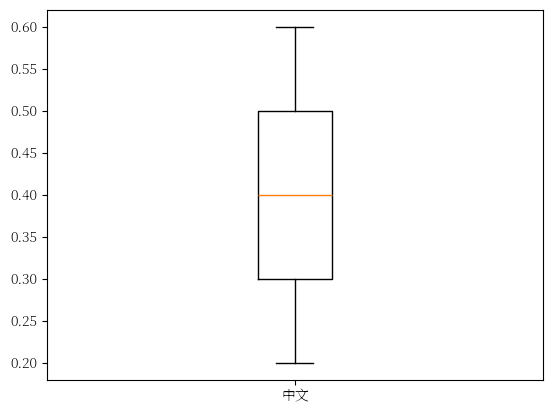

In [28]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 下載繁體中文字型
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf

# 加入字型檔
fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')

# 設定字型
mpl.rc('font', family='Source Han Serif TW VF')
data = [0.2, 0.4, 0.6]

# 這裡繪製出中文
labels = ['中文']

plt.boxplot(data, labels=labels)
plt.show()

## 1.4 載入真實肺癌數據

### 數據集欄位說明

| 欄位名稱 | 說明 | 單位/範圍 | 臨床意義 |
|---------|------|----------|----------|
| `inst` | 醫療機構代碼 | 數值 | 用於多中心試驗分析 |
| `time` | **生存時間** | 天數 | 從診斷到死亡或最後追蹤的天數 |
| `status` | **事件狀態** | 1=死亡, 2=存活（設限） | 1 表示觀察到死亡事件 |
| `age` | 年齡 | 歲 | 診斷時年齡 |
| `sex` | 性別 | 1=男性, 2=女性 | 生物學性別 |
| `ph.ecog` | **ECOG 體能狀態** | 0-3 | 0=完全活動, 3=臥床 >50% 時間 |
| `ph.karno` | **Karnofsky 評分（醫師）** | 0-100 | 醫師評估，100=正常，0=死亡 |
| `pat.karno` | **Karnofsky 評分（病患）** | 0-100 | 病患自評 |
| `meal.cal` | 每日攝取熱量 | 卡路里 | 營養狀態指標 |
| `wt.loss` | 體重減輕 | 磅（6個月內） | 負值表示體重增加 |

### 重要臨床量表說明

**ECOG Performance Status（體能狀態評分）**  
- 0：完全活動，能進行所有發病前的活動  
- 1：限制費力活動，但能行走及進行輕工作  
- 2：能行走及自理，但無法工作，白天 >50% 時間不臥床  
- 3：僅能有限自理，白天 >50% 時間臥床或坐椅  
- 4：完全失能，完全臥床  

**Karnofsky Performance Score（體能評分）**  
- 100-90：正常活動，無需特殊照顧  
- 80-70：能自理，無法正常活動或工作  
- 60-50：需要協助，經常需要醫療照護  
- 40-30：失能，需要特殊照護  
- 20-10：病重，需要住院  

In [29]:
# 載入 NCCTG Lung Cancer Dataset
print("📥 正在載入 NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

print(f"\n✅ 資料載入完成！")
print(f"   樣本數: {len(df_raw)} 位病患")
print(f"   特徵數: {df_raw.shape[1]} 個欄位")

# 顯示前 10 筆資料
print("\n📊 資料集預覽（前 10 筆）：\n")
display(df_raw.head(10))

# 資料集基本資訊
print("\n📋 資料集基本資訊：\n")
df_raw.info()

# 敘述統計
print("\n📈 敘述統計：\n")
display(df_raw.describe())

# 缺失值統計
print("\n⚠️  缺失值統計：\n")
missing_stats = pd.DataFrame({
    '缺失數量': df_raw.isnull().sum(),
    '缺失比例 (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['缺失數量'] > 0].sort_values('缺失數量', ascending=False)
display(missing_stats)

📥 正在載入 NCCTG Lung Cancer Dataset...

✅ 資料載入完成！
   樣本數: 228 位病患
   特徵數: 10 個欄位

📊 資料集預覽（前 10 筆）：



,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0
5,12.0,1022,0,74,1,1.0,50.0,80.0,513.0,0.0
6,7.0,310,1,68,2,2.0,70.0,60.0,384.0,10.0
7,11.0,361,1,71,2,2.0,60.0,80.0,538.0,1.0
8,1.0,218,1,53,1,1.0,70.0,80.0,825.0,16.0
9,7.0,166,1,61,1,2.0,70.0,70.0,271.0,34.0



📋 資料集基本資訊：

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB

📈 敘述統計：



,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,227.000,228.000,228.000,228.000,228.000,227.000,227.000,225.000,181.000,214.000
mean,11.088,305.232,0.724,62.447,1.395,0.952,81.938,79.956,928.779,9.832
std,8.303,210.646,0.448,9.073,0.490,0.718,12.328,14.623,402.175,13.140
min,1.000,5.000,0.000,39.000,1.000,0.000,50.000,30.000,96.000,-24.000
25%,3.000,166.750,0.000,56.000,1.000,0.000,75.000,70.000,635.000,0.000
50%,11.000,255.500,1.000,63.000,1.000,1.000,80.000,80.000,975.000,7.000
75%,16.000,396.500,1.000,69.000,2.000,1.000,90.000,90.000,1150.000,15.750
max,33.000,1022.000,1.000,82.000,2.000,3.000,100.000,100.000,2600.000,68.000



⚠️  缺失值統計：



,缺失數量,缺失比例 (%)
meal.cal,47,20.61
wt.loss,14,6.14
pat.karno,3,1.32
inst,1,0.44
ph.ecog,1,0.44
ph.karno,1,0.44


---
# 💾 第二部分：資料庫建立與 SQL 操作

## 2.1 建立 SQLite 資料庫

我們將資料分為三個表格，模擬真實醫院資料庫結構：

1. **patients** - 病患基本資料（人口統計學）
2. **clinical_data** - 臨床評估資料（ECOG、Karnofsky）
3. **survival_data** - 生存追蹤資料（時間、事件狀態）

In [30]:
# 連接到 SQLite 資料庫（如不存在會自動創建）
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"✅ 已連接到資料庫: {db_path}")

# 刪除舊表格（如果存在）
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

# 創建 patients 表格
cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")

# 創建 clinical_data 表格
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 創建 survival_data 表格
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

conn.commit()
print("\n✅ 已創建三個表格：patients, clinical_data, survival_data")

✅ 已連接到資料庫: lung_cancer.db

✅ 已創建三個表格：patients, clinical_data, survival_data


## 2.2 資料插入

將原始資料分別插入到三個表格中。

In [31]:
# 準備資料（新增 patient_id 欄位）
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

# 插入 patients 資料
patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data.to_sql('patients', conn, if_exists='replace', index=False)
print(f"✅ 已插入 {len(patients_data)} 筆病患基本資料")

# 插入 clinical_data 資料
clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='replace', index=False)
print(f"✅ 已插入 {len(clinical_data)} 筆臨床評估資料")

# 插入 survival_data 資料
survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='replace', index=False)
print(f"✅ 已插入 {len(survival_data)} 筆生存追蹤資料")

conn.commit()
print("\n✅ 所有資料插入完成！")

✅ 已插入 228 筆病患基本資料
✅ 已插入 228 筆臨床評估資料
✅ 已插入 228 筆生存追蹤資料

✅ 所有資料插入完成！


## 2.3 SQL 查詢示範

展示常用的 SQL 操作：SELECT、JOIN、聚合函數、篩選等。

In [32]:
# 查詢 1：基本 SELECT
print("📊 查詢 1：顯示前 5 位病患基本資料\n")
query1 = "SELECT * FROM patients LIMIT 5"
df_query1 = pd.read_sql_query(query1, conn)
display(df_query1)

# 查詢 2：JOIN 多表
print("\n📊 查詢 2：合併三個表格（完整病患資料）\n")
query2 = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    c.ph_ecog,
    c.ph_karno,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
LIMIT 5
"""
df_query2 = pd.read_sql_query(query2, conn)
display(df_query2)

# 查詢 3：聚合函數（GROUP BY）
print("\n📊 查詢 3：依性別統計平均年齡與生存時間\n")
query3 = """
SELECT
    p.sex,
    COUNT(*) as 人數,
    ROUND(AVG(p.age), 1) as 平均年齡,
    ROUND(AVG(s.time), 1) as 平均生存天數,
    SUM(CASE WHEN s.status = 1 THEN 1 ELSE 0 END) as 死亡人數
FROM patients p
INNER JOIN survival_data s ON p.patient_id = s.patient_id
GROUP BY p.sex
"""
df_query3 = pd.read_sql_query(query3, conn)
display(df_query3)

# 查詢 4：WHERE 條件篩選
print("\n📊 查詢 4：篩選高風險病患（ECOG ≥ 2 且年齡 > 65）\n")
query4 = """
SELECT
    p.patient_id,
    p.age,
    c.ph_ecog,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
WHERE c.ph_ecog >= 2 AND p.age > 65 AND c.ph_ecog IS NOT NULL
ORDER BY s.time ASC
LIMIT 10
"""
df_query4 = pd.read_sql_query(query4, conn)
display(df_query4)

# 查詢 5：計算生存率（Kaplan-Meier 前置準備）
print("\n📊 查詢 5：計算不同 ECOG 分組的中位生存時間\n")
query5 = """
SELECT
    c.ph_ecog as ECOG評分,
    COUNT(*) as 病患數,
    ROUND(AVG(s.time), 1) as 平均生存天數,
    MIN(s.time) as 最短生存天數,
    MAX(s.time) as 最長生存天數
FROM clinical_data c
INNER JOIN survival_data s ON c.patient_id = s.patient_id
WHERE c.ph_ecog IS NOT NULL
GROUP BY c.ph_ecog
ORDER BY c.ph_ecog
"""
df_query5 = pd.read_sql_query(query5, conn)
display(df_query5)

print("\n✅ SQL 查詢示範完成")

📊 查詢 1：顯示前 5 位病患基本資料



,patient_id,age,sex,inst
0,1,74,1,3.0
1,2,68,1,3.0
2,3,56,1,3.0
3,4,57,1,5.0
4,5,60,1,1.0



📊 查詢 2：合併三個表格（完整病患資料）



,patient_id,age,sex,ph_ecog,ph_karno,time,status
0,1,74,1,1.0,90.0,306,1
1,2,68,1,0.0,90.0,455,1
2,3,56,1,0.0,90.0,1010,0
3,4,57,1,1.0,90.0,210,1
4,5,60,1,0.0,100.0,883,1



📊 查詢 3：依性別統計平均年齡與生存時間



,sex,人數,平均年齡,平均生存天數,死亡人數
0,1,138,63.3,283.2,112
1,2,90,61.1,339.0,53



📊 查詢 4：篩選高風險病患（ECOG ≥ 2 且年齡 > 65）



,patient_id,age,ph_ecog,time,status
0,73,74,2.0,11,1
1,30,74,2.0,12,1
2,116,76,2.0,13,1
3,32,73,2.0,26,1
4,96,72,2.0,30,1
5,124,72,2.0,54,1
6,66,68,2.0,65,1
7,39,74,2.0,93,1
8,46,76,2.0,95,1
9,226,75,2.0,105,0



📊 查詢 5：計算不同 ECOG 分組的中位生存時間



,ECOG評分,病患數,平均生存天數,最短生存天數,最長生存天數
0,0.0,63,351.9,5,1010
1,1.0,113,314.4,11,1022
2,2.0,50,234.1,11,814
3,3.0,1,118.0,118,118



✅ SQL 查詢示範完成


---
# 🧹 第三部分：資料清理與特徵工程

## 3.1 缺失值處理

根據前面的缺失值統計，我們發現部分欄位有缺失：
- `inst`: 63 筆 (27.6%)
- `wt.loss`: 14 筆 (6.1%)
- `meal.cal`: 47 筆 (20.6%)
- `pat.karno` / `ph.karno` / `ph.ecog`: 少量缺失

**處理策略**：
1. 核心變數（`time`, `status`, `age`, `sex`）：無缺失，不需處理
2. 臨床評分（`ph.ecog`, `ph.karno`）：中位數填補
3. 體重/熱量：中位數填補
4. 醫療機構：保留缺失（不影響生存分析）

In [33]:
# 從資料庫讀取完整資料
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.inst as inst, -- 修正：將 p.institution 改為 p.inst
    c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)

print("📋 清理前資料狀態：")
print(f"   樣本數: {len(df)}")
print(f"   缺失值總數: {df.isnull().sum().sum()}")

# 缺失值填補
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

print("\n✅ 清理後資料狀態：")
print(f"   樣本數: {len(df)}")
print(f"   缺失值總數: {df.isnull().sum().sum()}")

# 儲存清理後的資料
df.to_csv('lung_cancer_cleaned.csv', index=False, encoding='utf-8-sig')
print("\n💾 已儲存清理後資料: lung_cancer_cleaned.csv")

📋 清理前資料狀態：
   樣本數: 228
   缺失值總數: 67

✅ 清理後資料狀態：
   樣本數: 228
   缺失值總數: 1

💾 已儲存清理後資料: lung_cancer_cleaned.csv


## 3.2 特徵工程

創建新的特徵以便後續分析：
1. **性別標籤**：1=男性, 2=女性 → 轉為文字
2. **ECOG 分組**：0-1（良好） vs 2-3（不良）
3. **年齡分組**：<65 歲 vs ≥65 歲（老年定義）
4. **事件標籤**：1=死亡, 2=存活 → 轉為文字
5. **Karnofsky 分組**：<70（不良） vs ≥70（良好）

In [34]:
# 性別標籤
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})

# 事件標籤（注意：原始資料 status=2 是死亡，需轉換）
# lifelines 資料集的 status: 1=死亡（censored=False）, 2=存活（censored=True）
# 標準化為：1=死亡事件, 0=設限
df['event'] = (df['status'] == 1).astype(int)  # 原本 status=1 就是死亡
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})

# ECOG 分組
df['ECOG分組'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)

# 年齡分組
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)

# Karnofsky 分組（醫師評分）
df['Karnofsky分組'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)

# 生存時間（月）
df['生存月數'] = (df['time'] / 30.44).round(1)

print("✅ 特徵工程完成！")
print("\n新增欄位：")
print("   - 性別（文字標籤）")
print("   - event（標準化事件狀態：0/1）")
print("   - 事件狀態（文字標籤）")
print("   - ECOG分組")
print("   - 年齡分組")
print("   - Karnofsky分組")
print("   - 生存月數")

# 顯示處理後的資料
print("\n📊 處理後資料預覽：\n")
display(df[[
    'patient_id', 'age', '性別', 'ph_ecog', 'ECOG分組',
    'time', '生存月數', 'event', '事件狀態'
]].head(10))

# 統計摘要
print("\n📈 分組統計：\n")
print("性別分佈：")
print(df['性別'].value_counts())
print("\nECOG 分組：")
print(df['ECOG分組'].value_counts())
print("\n事件狀態：")
print(df['事件狀態'].value_counts())

✅ 特徵工程完成！

新增欄位：
   - 性別（文字標籤）
   - event（標準化事件狀態：0/1）
   - 事件狀態（文字標籤）
   - ECOG分組
   - 年齡分組
   - Karnofsky分組
   - 生存月數

📊 處理後資料預覽：



,patient_id,age,性別,ph_ecog,ECOG分組,time,生存月數,event,事件狀態
0,1,74,男性,1.0,良好 (0-1),306,10.1,1,死亡
1,2,68,男性,0.0,良好 (0-1),455,14.9,1,死亡
2,3,56,男性,0.0,良好 (0-1),1010,33.2,0,存活（設限）
3,4,57,男性,1.0,良好 (0-1),210,6.9,1,死亡
4,5,60,男性,0.0,良好 (0-1),883,29.0,1,死亡
5,6,74,男性,1.0,良好 (0-1),1022,33.6,0,存活（設限）
6,7,68,女性,2.0,不良 (2-3),310,10.2,1,死亡
7,8,71,女性,2.0,不良 (2-3),361,11.9,1,死亡
8,9,53,男性,1.0,良好 (0-1),218,7.2,1,死亡
9,10,61,男性,2.0,不良 (2-3),166,5.5,1,死亡



📈 分組統計：

性別分佈：
性別
男性    138
女性     90
Name: count, dtype: int64

ECOG 分組：
ECOG分組
良好 (0-1)    177
不良 (2-3)     51
Name: count, dtype: int64

事件狀態：
事件狀態
死亡        165
存活（設限）     63
Name: count, dtype: int64


---
# 📊 第四部分：探索性資料分析（Exploratory Data Analysis）

## 4.1 人口統計學分析

透過視覺化了解病患群體的基本特徵分佈。

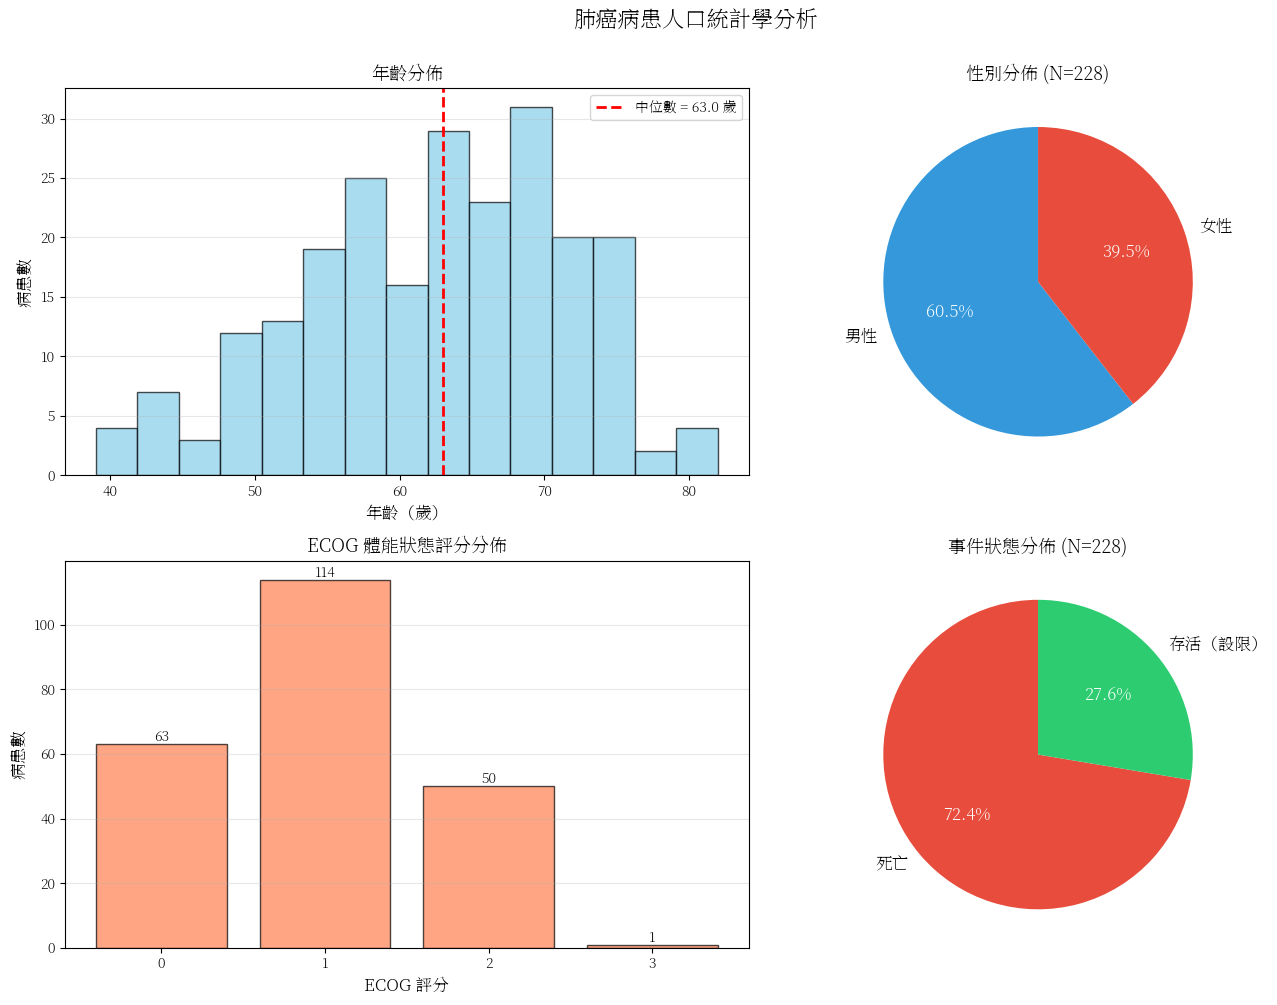

✅ 圖 1 已生成並儲存：圖1_人口統計學分析.png


In [35]:
# 創建圖表布局
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('肺癌病患人口統計學分析', fontsize=16, fontweight='bold', y=1.00)

# 子圖 1：年齡分佈
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['age'].median(), color='red', linestyle='--', linewidth=2,
            label=f'中位數 = {df["age"].median():.1f} 歲')
ax1.set_xlabel('年齡（歲）', fontsize=12)
ax1.set_ylabel('病患數', fontsize=12)
ax1.set_title('年齡分佈', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子圖 2：性別分佈
ax2 = axes[0, 1]
sex_counts = df['性別'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title(f'性別分佈 (N={len(df)})', fontsize=13, fontweight='bold')

# 子圖 3：ECOG 評分分佈
ax3 = axes[1, 0]
ecog_counts = df['ph_ecog'].value_counts().sort_index()
bars = ax3.bar(ecog_counts.index, ecog_counts.values, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('ECOG 評分', fontsize=12)
ax3.set_ylabel('病患數', fontsize=12)
ax3.set_title('ECOG 體能狀態評分分佈', fontsize=13, fontweight='bold')
ax3.set_xticks([0, 1, 2, 3])
ax3.grid(axis='y', alpha=0.3)
# 加上數值標籤
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 子圖 4：事件狀態
ax4 = axes[1, 1]
event_counts = df['事件狀態'].value_counts()
colors_event = ['#e74c3c', '#2ecc71']
wedges, texts, autotexts = ax4.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors_event, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title(f'事件狀態分佈 (N={len(df)})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('圖1_人口統計學分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 1 已生成並儲存：圖1_人口統計學分析.png")

## 4.2 臨床評分分析

比較醫師評分（ph.karno）與病患自評（pat.karno）的差異。

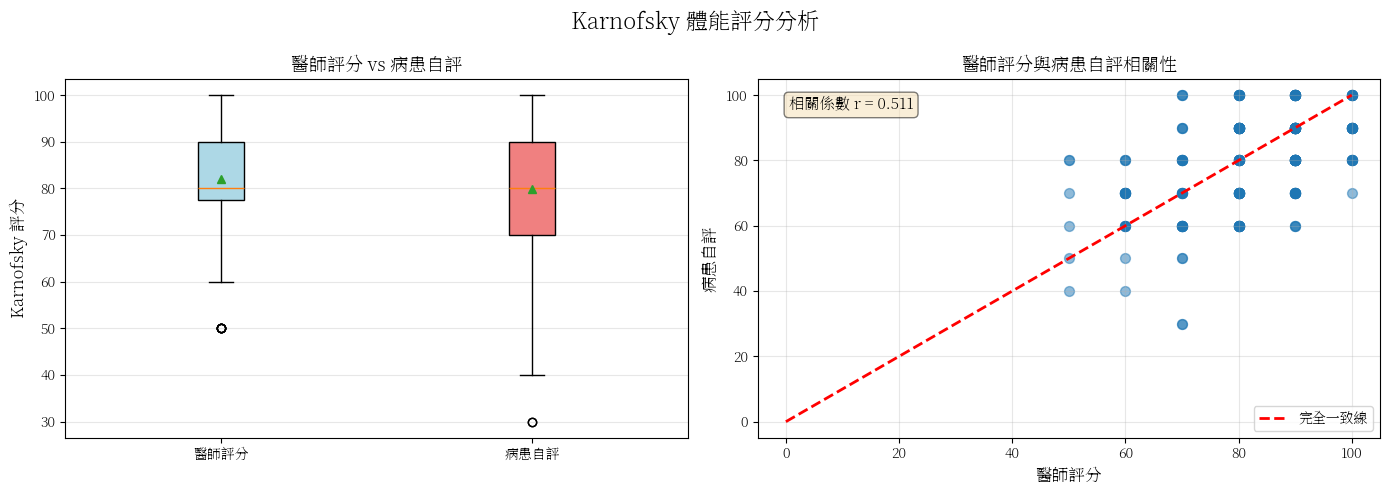

✅ 圖 2 已生成並儲存：圖2_Karnofsky評分分析.png

📊 統計檢定結果：
   醫師評分平均：81.93 ± 12.30
   病患自評平均：79.96 ± 14.53
   Pearson 相關係數：r = 0.511
   配對 t 檢定：t = 2.223, p = 0.0272
   ✅ 結論：醫師評分與病患自評有顯著差異（p < 0.05）


In [36]:
# 創建圖表布局
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Karnofsky 體能評分分析', fontsize=16, fontweight='bold')

# 子圖 1：Box Plot 比較
ax1 = axes[0]
data_to_plot = [df['ph_karno'].dropna(), df['pat_karno'].dropna()]
bp = ax1.boxplot(data_to_plot, labels=['醫師評分', '病患自評'],
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax1.set_ylabel('Karnofsky 評分', fontsize=12)
ax1.set_title('醫師評分 vs 病患自評', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 子圖 2：Scatter Plot（相關性）
ax2 = axes[1]
ax2.scatter(df['ph_karno'], df['pat_karno'], alpha=0.5, s=50)
ax2.plot([0, 100], [0, 100], 'r--', linewidth=2, label='完全一致線')
ax2.set_xlabel('醫師評分', fontsize=12)
ax2.set_ylabel('病患自評', fontsize=12)
ax2.set_title('醫師評分與病患自評相關性', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 計算相關係數
corr = df[['ph_karno', 'pat_karno']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'相關係數 r = {corr:.3f}',
         transform=ax2.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('圖2_Karnofsky評分分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 2 已生成並儲存：圖2_Karnofsky評分分析.png")
print(f"\n📊 統計檢定結果：")
print(f"   醫師評分平均：{df['ph_karno'].mean():.2f} ± {df['ph_karno'].std():.2f}")
print(f"   病患自評平均：{df['pat_karno'].mean():.2f} ± {df['pat_karno'].std():.2f}")
print(f"   Pearson 相關係數：r = {corr:.3f}")

# Paired t-test
t_stat, p_value = stats.ttest_rel(df['ph_karno'].dropna(), df['pat_karno'].dropna())
print(f"   配對 t 檢定：t = {t_stat:.3f}, p = {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✅ 結論：醫師評分與病患自評有顯著差異（p < 0.05）")
else:
    print(f"   ⚠️  結論：醫師評分與病患自評無顯著差異（p ≥ 0.05)")

## 4.3 生存時間分佈

了解生存時間的整體分佈與不同群體的差異。

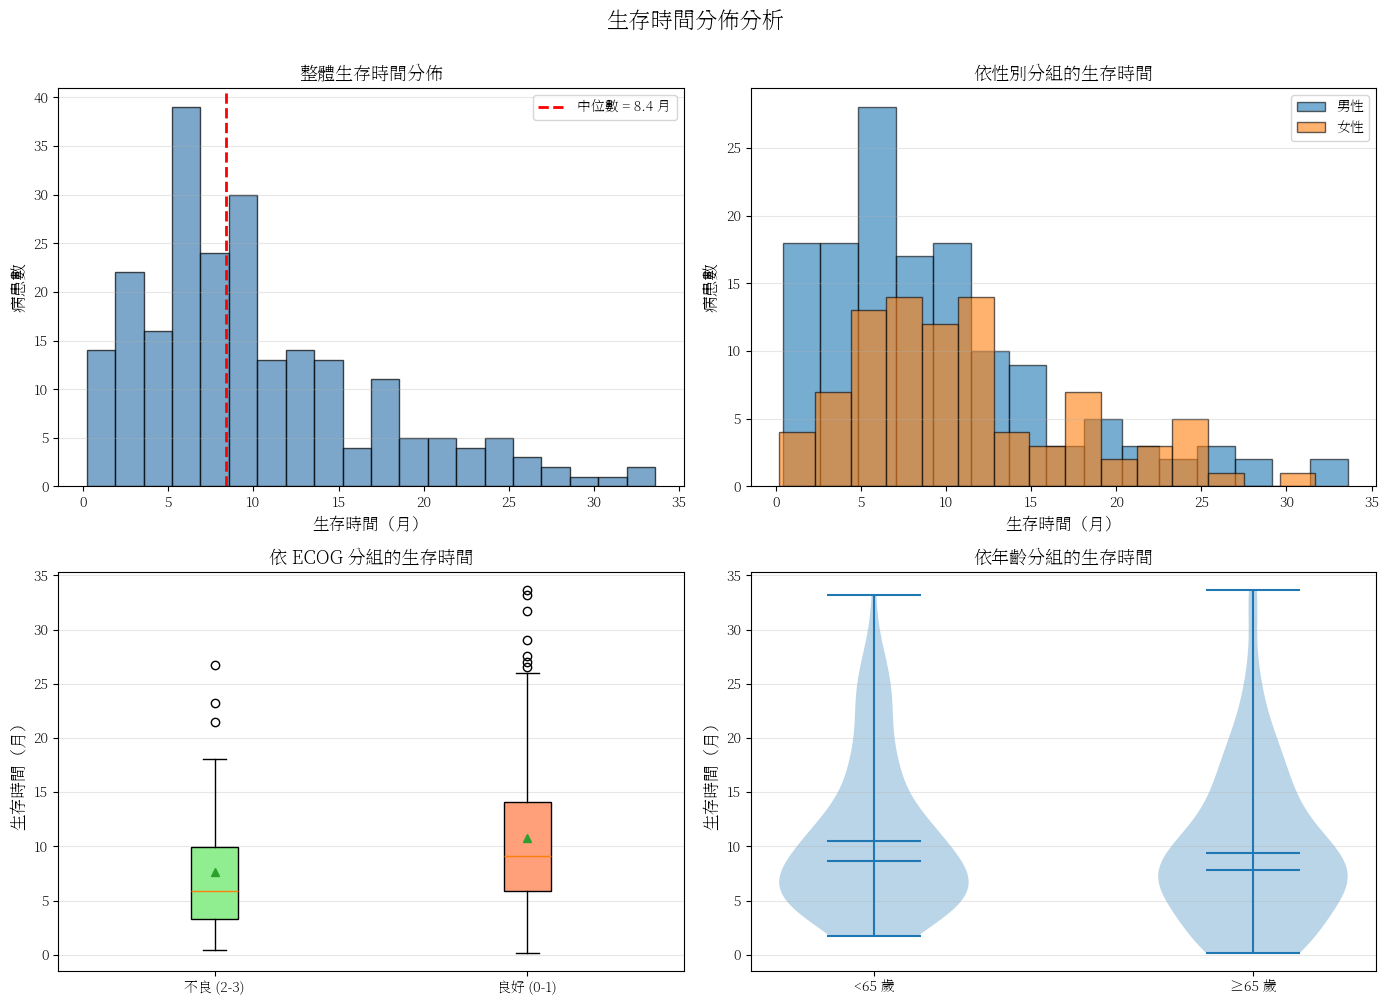

✅ 圖 3 已生成並儲存：圖3_生存時間分佈.png

📊 生存時間統計摘要：

    count    mean    std  min    25%   50%    75%   max
性別                                                     
女性   90.0  11.134  6.686  0.2  6.425  9.60  14.75  31.7
男性  138.0   9.307  6.998  0.4  4.725  7.35  12.15  33.6


          count    mean    std  min   25%  50%   75%   max
ECOG分組                                                    
不良 (2-3)   51.0   7.616  6.195  0.4  3.25  5.9   9.9  26.7
良好 (0-1)  177.0  10.723  6.977  0.2  5.90  9.1  14.1  33.6


In [37]:
# 創建圖表
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('生存時間分佈分析', fontsize=16, fontweight='bold', y=1.00)

# 子圖 1：整體生存時間分佈
ax1 = axes[0, 0]
ax1.hist(df['生存月數'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['生存月數'].median(), color='red', linestyle='--', linewidth=2,
            label=f'中位數 = {df["生存月數"].median():.1f} 月')
ax1.set_xlabel('生存時間（月）', fontsize=12)
ax1.set_ylabel('病患數', fontsize=12)
ax1.set_title('整體生存時間分佈', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子圖 2：依性別分組
ax2 = axes[0, 1]
for sex_label in df['性別'].unique():
    data = df[df['性別'] == sex_label]['生存月數']
    ax2.hist(data, bins=15, alpha=0.6, label=sex_label, edgecolor='black')
ax2.set_xlabel('生存時間（月）', fontsize=12)
ax2.set_ylabel('病患數', fontsize=12)
ax2.set_title('依性別分組的生存時間', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 子圖 3：依 ECOG 分組（Box Plot）
ax3 = axes[1, 0]
ecog_groups = df.groupby('ECOG分組')['生存月數'].apply(list)
bp = ax3.boxplot(ecog_groups.values, labels=ecog_groups.index,
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightsalmon']):
    patch.set_facecolor(color)
ax3.set_ylabel('生存時間（月）', fontsize=12)
ax3.set_title('依 ECOG 分組的生存時間', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 子圖 4：依年齡分組（Violin Plot）
ax4 = axes[1, 1]
age_groups = df.groupby('年齡分組')['生存月數'].apply(list)
parts = ax4.violinplot(age_groups.values, positions=[1, 2],
                        showmeans=True, showmedians=True)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(age_groups.index)
ax4.set_ylabel('生存時間（月）', fontsize=12)
ax4.set_title('依年齡分組的生存時間', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('圖3_生存時間分佈.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 3 已生成並儲存：圖3_生存時間分佈.png")

# 統計摘要
print("\n📊 生存時間統計摘要：\n")
print(df.groupby('性別')['生存月數'].describe())
print("\n")
print(df.groupby('ECOG分組')['生存月數'].describe())

---
# 📈 第五部分：生存分析（Survival Analysis）

## 5.1 整體 Kaplan-Meier 生存曲線

**Kaplan-Meier 估計量**是生存分析中最常用的非參數方法，用於估計生存函數。

**公式**：
$$
\hat{S}(t) = \prod_{t_i \leq t} \left( 1 - \frac{d_i}{n_i} \right)
$$

其中：
- $d_i$ = 在時間 $t_i$ 發生事件的人數
- $n_i$ = 在時間 $t_i$ 仍處於風險中的人數

**臨床意義**：
- 生存曲線顯示隨時間推移，病患存活的機率
- 中位生存時間（median survival time）：50% 病患存活的時間點
- 信賴區間（95% CI）：顯示估計的不確定性

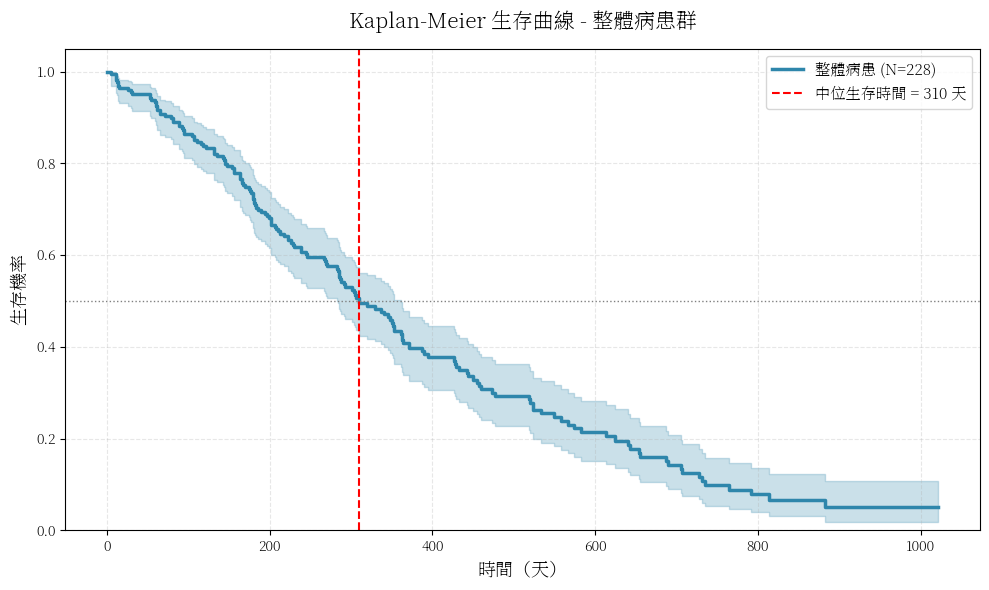

✅ 圖 4 已生成並儲存：圖4_整體KM曲線.png

📊 整體生存分析結果：
   中位生存時間：310 天 (10.2 月)
   1 年生存率：40.9%
   觀察到的事件數：165 / 228 (72.4%)


In [38]:
# 創建 Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# 擬合整體資料
kmf.fit(durations=df['time'], event_observed=df['event'], label='整體病患 (N=228)')

# 繪製生存曲線
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True, color='#2E86AB', linewidth=2.5)
plt.xlabel('時間（天）', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 整體病患群', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])

# 加上中位生存時間標記
median_survival = kmf.median_survival_time_
if not np.isnan(median_survival):
    plt.axvline(median_survival, color='red', linestyle='--', linewidth=1.5,
                label=f'中位生存時間 = {median_survival:.0f} 天')
    plt.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig('圖4_整體KM曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 4 已生成並儲存：圖4_整體KM曲線.png")
print(f"\n📊 整體生存分析結果：")
print(f"   中位生存時間：{median_survival:.0f} 天 ({median_survival/30.44:.1f} 月)")
print(f"   1 年生存率：{kmf.survival_function_at_times(365).values[0]:.1%}")
print(f"   觀察到的事件數：{df['event'].sum()} / {len(df)} ({df['event'].mean():.1%})")

## 5.2 依性別分層的生存曲線

比較男性與女性病患的生存差異。

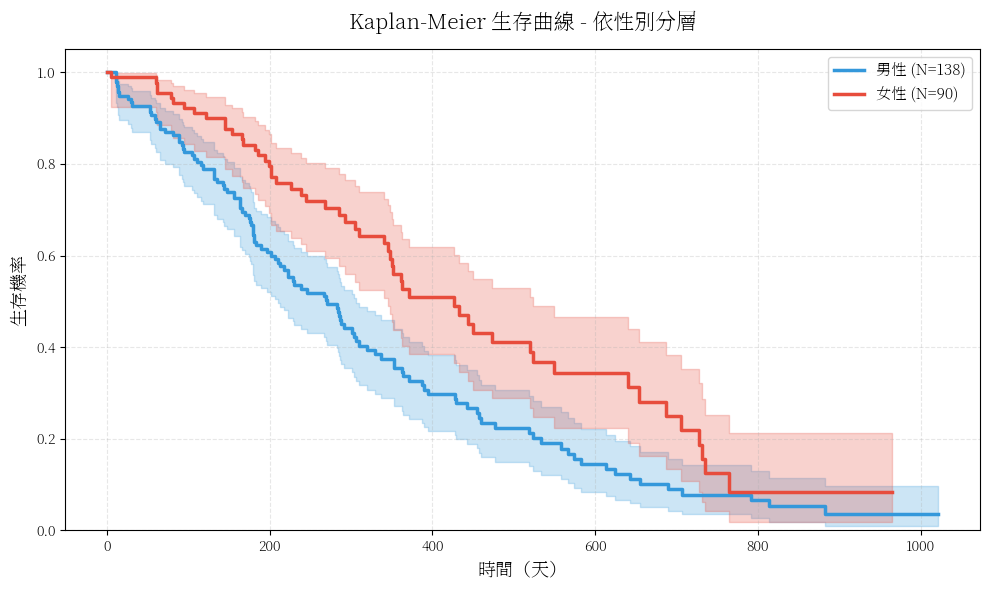

✅ 圖 5 已生成並儲存：圖5_性別分層KM曲線.png

📊 Log-Rank 檢定結果（性別差異）：
   檢定統計量：10.327
   p 值：0.0013
   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）


In [39]:
# 繪製依性別分層的生存曲線
plt.figure(figsize=(10, 6))

colors = {'男性': '#3498db', '女性': '#e74c3c'}
for sex_label in df['性別'].unique():
    mask = df['性別'] == sex_label
    kmf_sex = KaplanMeierFitter()
    kmf_sex.fit(durations=df[mask]['time'],
                event_observed=df[mask]['event'],
                label=f'{sex_label} (N={mask.sum()})')
    kmf_sex.plot_survival_function(ci_show=True, color=colors[sex_label], linewidth=2.5)

plt.xlabel('時間（天）', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 依性別分層', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.savefig('圖5_性別分層KM曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 5 已生成並儲存：圖5_性別分層KM曲線.png")

# Log-Rank 檢定
male_mask = df['性別'] == '男性'
female_mask = df['性別'] == '女性'

results = logrank_test(
    durations_A=df[male_mask]['time'],
    durations_B=df[female_mask]['time'],
    event_observed_A=df[male_mask]['event'],
    event_observed_B=df[female_mask]['event']
)

print(f"\n📊 Log-Rank 檢定結果（性別差異）：")
print(f"   檢定統計量：{results.test_statistic:.3f}")
print(f"   p 值：{results.p_value:.4f}")
if results.p_value < 0.05:
    print(f"   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ⚠️  結論：男性與女性的生存曲線無顯著差異（p ≥ 0.05）")

## 5.3 依 ECOG 體能狀態分層的生存曲線

**ECOG 評分是肺癌預後的重要指標**，評分越高表示體能狀態越差，預期生存時間越短。

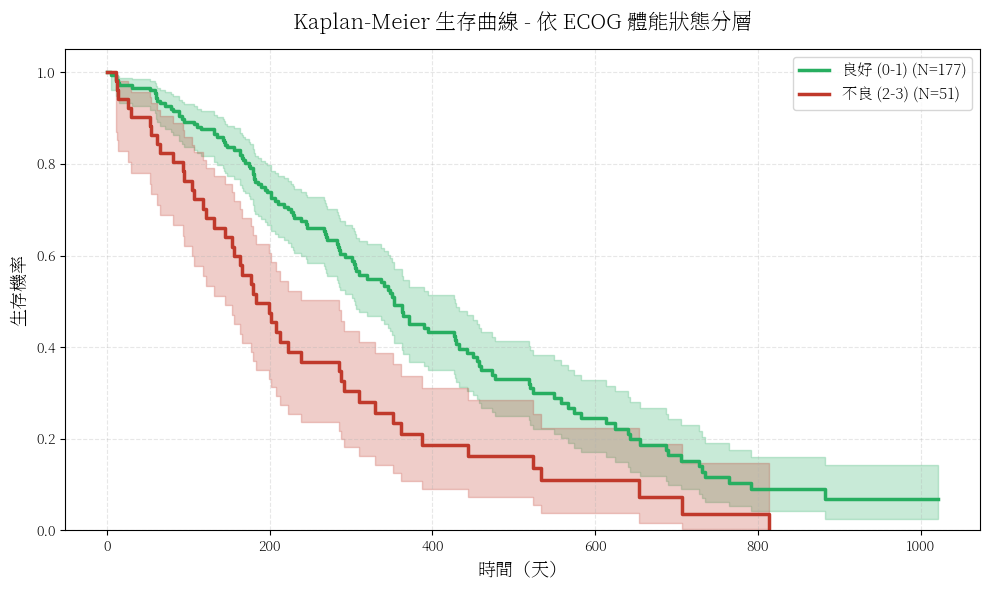

✅ 圖 6 已生成並儲存：圖6_ECOG分層KM曲線.png

📊 Log-Rank 檢定結果（ECOG 差異）：
   檢定統計量：15.547
   p 值：0.0001
   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）


In [40]:
# 繪製依 ECOG 分層的生存曲線
plt.figure(figsize=(10, 6))

colors_ecog = {'良好 (0-1)': '#27ae60', '不良 (2-3)': '#c0392b'}
for ecog_group in df['ECOG分組'].unique():
    mask = df['ECOG分組'] == ecog_group
    kmf_ecog = KaplanMeierFitter()
    kmf_ecog.fit(durations=df[mask]['time'],
                 event_observed=df[mask]['event'],
                 label=f'{ecog_group} (N={mask.sum()})')
    kmf_ecog.plot_survival_function(ci_show=True, color=colors_ecog[ecog_group], linewidth=2.5)

plt.xlabel('時間（天）', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 依 ECOG 體能狀態分層', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.savefig('圖6_ECOG分層KM曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 6 已生成並儲存：圖6_ECOG分層KM曲線.png")

# Log-Rank 檢定
good_mask = df['ECOG分組'] == '良好 (0-1)'
poor_mask = df['ECOG分組'] == '不良 (2-3)'

results_ecog = logrank_test(
    durations_A=df[good_mask]['time'],
    durations_B=df[poor_mask]['time'],
    event_observed_A=df[good_mask]['event'],
    event_observed_B=df[poor_mask]['event']
)

print(f"\n📊 Log-Rank 檢定結果（ECOG 差異）：")
print(f"   檢定統計量：{results_ecog.test_statistic:.3f}")
print(f"   p 值：{results_ecog.p_value:.4f}")
if results_ecog.p_value < 0.05:
    print(f"   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ⚠️  結論：ECOG 良好組與不良組的生存曲線無顯著差異（p ≥ 0.05）")

## 5.4 Cox 比例風險模型（Multivariable Analysis）

**Cox 比例風險模型**是生存分析中最常用的多變量回歸方法。

**模型公式**：
$$
h(t|X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p)
$$

其中：
- $h(t|X)$ = 給定共變數 $X$ 下的風險函數
- $h_0(t)$ = 基線風險函數（baseline hazard）
- $\beta$ = 回歸係數

**風險比（Hazard Ratio, HR）解釋**：
- $HR = \exp(\beta)$
- HR > 1：增加死亡風險（預後不良因子）
- HR < 1：降低死亡風險（保護因子）
- HR = 1：無影響

**納入變數**：
- 年齡（連續變數）
- 性別（類別變數：男性 vs 女性）
- ECOG 評分（連續變數）
- Karnofsky 評分（連續變數）

📊 Cox 比例風險模型結果：

            coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                               
age        0.012      1.012     0.009          -0.006           0.031   
sex       -0.584      0.558     0.169          -0.915          -0.254   
ph_ecog    0.625      1.869     0.174           0.284           0.966   
ph_karno   0.012      1.012     0.009          -0.007           0.030   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to      z          p  \
covariate                                                                       
age                      0.994                1.031     0.0  1.318  1.874e-01   
sex                      0.401                0.776     0.0 -3.463  5.336e-04   
ph_ecog                  1.328                2.629     0.0  3.591  3.290e-04   
ph_karno                 0.993                1.030     0.0  1.225  2.207e-01   

           -log2(p)  
covariate            
age          

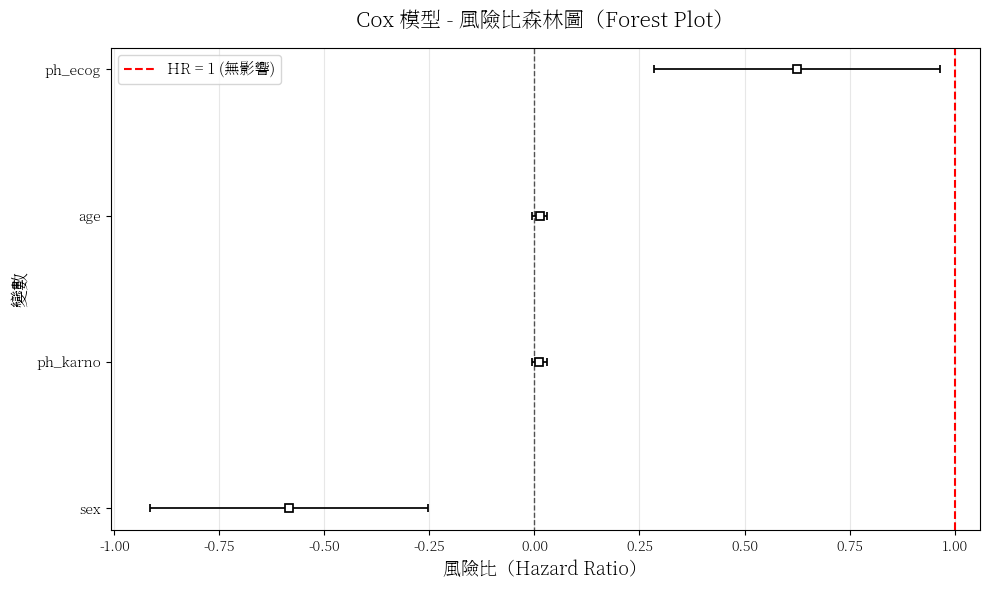


✅ 圖 7 已生成並儲存：圖7_Cox模型風險比.png

📋 模型解釋：

**age**
   HR = 1.012 (95% CI: 0.994-1.031)
   p = 0.1874
   ⚠️  無顯著影響（p ≥ 0.05）

**sex**
   HR = 0.558 (95% CI: 0.401-0.776)
   p = 0.0005
   ✅ 顯著的保護因子（降低 44.2% 死亡風險）

**ph_ecog**
   HR = 1.869 (95% CI: 1.328-2.629)
   p = 0.0003
   ✅ 顯著的預後不良因子（增加 86.9% 死亡風險）

**ph_karno**
   HR = 1.012 (95% CI: 0.993-1.030)
   p = 0.2207
   ⚠️  無顯著影響（p ≥ 0.05）


📊 模型診斷：
   Concordance Index (C-index): 0.634
   （C-index > 0.7 表示模型預測能力良好）
   AIC: 1475.52
   Log-likelihood: -733.76


In [41]:
# 準備 Cox 模型資料
cox_df = df[['time', 'event', 'age', 'sex', 'ph_ecog', 'ph_karno']].copy()

# 創建 Cox PH Fitter
cph = CoxPHFitter()

# 擬合模型
cph.fit(cox_df, duration_col='time', event_col='event')

# 顯示結果摘要
print("📊 Cox 比例風險模型結果：\n")
print(cph.summary)

# 視覺化風險比
plt.figure(figsize=(10, 6))
cph.plot()
plt.axvline(1, color='red', linestyle='--', linewidth=1.5, label='HR = 1 (無影響)')
plt.xlabel('風險比（Hazard Ratio）', fontsize=13)
plt.ylabel('變數', fontsize=13)
plt.title('Cox 模型 - 風險比森林圖（Forest Plot）', fontsize=15, fontweight='bold', pad=15)
plt.legend(fontsize=11)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('圖7_Cox模型風險比.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 圖 7 已生成並儲存：圖7_Cox模型風險比.png")

# 詳細解釋
print("\n📋 模型解釋：\n")
for var in cox_df.columns:
    if var not in ['time', 'event']:
        hr = cph.summary.loc[var, 'exp(coef)'] # 直接從 summary 取得 exp(coef)
        p_val = cph.summary.loc[var, 'p']
        # 從 cph.summary 取得 exp(coef) 的信賴區間
        ci_lower = cph.summary.loc[var, 'exp(coef) lower 95%']
        ci_upper = cph.summary.loc[var, 'exp(coef) upper 95%']

        print(f"**{var}**")
        print(f"   HR = {hr:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")
        print(f"   p = {p_val:.4f}")

        if p_val < 0.05:
            if hr > 1:
                print(f"   ✅ 顯著的預後不良因子（增加 {(hr-1)*100:.1f}% 死亡風險）")
            else:
                print(f"   ✅ 顯著的保護因子（降低 {(1-hr)*100:.1f}% 死亡風險）")
        else:
            print(f"   ⚠️  無顯著影響（p ≥ 0.05）")
        print()

# 模型診斷
print("\n📊 模型診斷：")
print(f"   Concordance Index (C-index): {cph.concordance_index_:.3f}")
print(f"   （C-index > 0.7 表示模型預測能力良好）")
print(f"   AIC: {cph.AIC_partial_:.2f}")
print(f"   Log-likelihood: {cph.log_likelihood_:.2f}")

---
# 📊 第六部分：Power BI 整合

## 6.1 匯出資料供 Power BI 使用

將清理後的資料匯出為 CSV 格式，供 Power BI 匯入使用。

In [42]:
# 匯出完整資料集
df.to_csv('PowerBI_LungCancer_Complete.csv', index=False, encoding='utf-8-sig')
print("✅ 已匯出完整資料集：PowerBI_LungCancer_Complete.csv")

# 匯出彙總資料（供 Power BI Dashboard 使用）
summary_df = pd.DataFrame({
    '性別': ['男性', '女性'],
    '病患數': [df[df['性別']=='男性'].shape[0], df[df['性別']=='女性'].shape[0]],
    '平均年齡': [df[df['性別']=='男性']['age'].mean(), df[df['性別']=='女性']['age'].mean()],
    '平均生存月數': [df[df['性別']=='男性']['生存月數'].mean(), df[df['性別']=='女性']['生存月數'].mean()],
    '死亡人數': [df[df['性別']=='男性']['event'].sum(), df[df['性別']=='女性']['event'].sum()]
})
summary_df.to_csv('PowerBI_Summary_Sex.csv', index=False, encoding='utf-8-sig')
print("✅ 已匯出性別彙總資料：PowerBI_Summary_Sex.csv")

# 匯出 ECOG 彙總資料
ecog_summary = pd.DataFrame({
    'ECOG分組': ['良好 (0-1)', '不良 (2-3)'],
    '病患數': [df[df['ECOG分組']=='良好 (0-1)'].shape[0], df[df['ECOG分組']=='不良 (2-3)'].shape[0]],
    '平均生存月數': [df[df['ECOG分組']=='良好 (0-1)']['生存月數'].mean(),
                       df[df['ECOG分組']=='不良 (2-3)']['生存月數'].mean()],
    '死亡人數': [df[df['ECOG分組']=='良好 (0-1)']['event'].sum(),
                 df[df['ECOG分組']=='不良 (2-3)']['event'].sum()]
})
ecog_summary.to_csv('PowerBI_Summary_ECOG.csv', index=False, encoding='utf-8-sig')
print("✅ 已匯出 ECOG 彙總資料：PowerBI_Summary_ECOG.csv")

print("\n📁 已生成 3 個 Power BI 資料檔案：")
print("   1. PowerBI_LungCancer_Complete.csv - 完整資料集")
print("   2. PowerBI_Summary_Sex.csv - 性別彙總")
print("   3. PowerBI_PowerBI_Summary_ECOG.csv - ECOG 彙總")

✅ 已匯出完整資料集：PowerBI_LungCancer_Complete.csv
✅ 已匯出性別彙總資料：PowerBI_Summary_Sex.csv
✅ 已匯出 ECOG 彙總資料：PowerBI_Summary_ECOG.csv

📁 已生成 3 個 Power BI 資料檔案：
   1. PowerBI_LungCancer_Complete.csv - 完整資料集
   2. PowerBI_Summary_Sex.csv - 性別彙總
   3. PowerBI_PowerBI_Summary_ECOG.csv - ECOG 彙總


## 6.2 SQLite 連接資訊

### 方法 1：CSV 匯入（建議）

**步驟**：
1. 開啟 Power BI Desktop
2. 選擇「取得資料」 → 「文字/CSV」
3. 選擇 `PowerBI_LungCancer_Complete.csv`
4. 點選「轉換資料」進行資料清理（如果需要）
5. 點選「載入」

### 方法 2：SQLite 直接連接

**連接字串**：
```
Data Source=lung_cancer.db;Version=3;
```

**步驟**：
1. 開啟 Power BI Desktop
2. 選擇「取得資料」 → 「更多」 → 「SQLite 資料庫」
3. 輸入資料庫路徑（絕對路徑）
4. 選擇要匯入的表格（patients, clinical_data, survival_data）
5. 使用「轉換資料」建立關聯（patient_id）

### 方法 3：Python 腳本（進階）

在 Power BI 中可以使用 Python 腳本直接執行查詢：

In [43]:
# 這段腳本可以直接在 Power BI 的 Python 視覺效果中使用
powerbi_script = '''
# Power BI Python 腳本範例
import sqlite3
import pandas as pd

# 連接資料庫
conn = sqlite3.connect('lung_cancer.db')

# 查詢完整資料
query = """
SELECT
    p.patient_id,
    p.age,
    CASE WHEN p.sex = 1 THEN '男性' ELSE '女性' END as 性別,
    c.ph_ecog as ECOG評分,
    c.ph_karno as Karnofsky評分,
    s.time as 生存天數,
    s.time / 30.44 as 生存月數,
    CASE WHEN s.status = 1 THEN '死亡' ELSE '存活' END as 狀態
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""

dataset = pd.read_sql_query(query, conn)
conn.close()
'''

print("Power BI Python 腳本：")
print("=" * 60)
print(powerbi_script)
print("=" * 60)

# 儲存腳本
with open('PowerBI_Python_Script.py', 'w', encoding='utf-8') as f:
    f.write(powerbi_script)
print("\n✅ 已儲存 Power BI Python 腳本：PowerBI_Python_Script.py")

Power BI Python 腳本：

# Power BI Python 腳本範例
import sqlite3
import pandas as pd

# 連接資料庫
conn = sqlite3.connect('lung_cancer.db')

# 查詢完整資料
query = """
SELECT
    p.patient_id,
    p.age,
    CASE WHEN p.sex = 1 THEN '男性' ELSE '女性' END as 性別,
    c.ph_ecog as ECOG評分,
    c.ph_karno as Karnofsky評分,
    s.time as 生存天數,
    s.time / 30.44 as 生存月數,
    CASE WHEN s.status = 1 THEN '死亡' ELSE '存活' END as 狀態
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""

dataset = pd.read_sql_query(query, conn)
conn.close()


✅ 已儲存 Power BI Python 腳本：PowerBI_Python_Script.py


## 6.3 Power BI DAX 公式範例

在 Power BI 中建立計算欄位和量值的 DAX 公式範例：

In [44]:
dax_formulas = '''
# ========== Power BI DAX 公式範例 ==========

# 1. 計算總病患數
總病患數 = COUNTROWS(LungCancer)

# 2. 計算死亡人數
死亡人數 = CALCULATE(COUNTROWS(LungCancer), LungCancer[event] = 1)

# 3. 計算死亡率
死亡率 = DIVIDE([死亡人數], [總病患數], 0)

# 4. 平均生存月數
平均生存月數 = AVERAGE(LungCancer[生存月數])

# 5. 中位生存月數
中位生存月數 = MEDIAN(LungCancer[生存月數])

# 6. 年齡分組（計算欄位）
年齡分組 =
    IF(
        LungCancer[age] < 65,
        "<65 歲",
        "≥65 歲"
    )

# 7. ECOG 風險分組（計算欄位）
ECOG風險 =
    IF(
        LungCancer[ph_ecog] <= 1,
        "低風險",
        "高風險"
    )

# 8. 依性別計算平均生存時間
男性平均生存月數 =
    CALCULATE(
        AVERAGE(LungCancer[生存月數]),
        LungCancer[性別] = "男性"
    )

女性平均生存月數 =
    CALCULATE(
        AVERAGE(LungCancer[生存月數]),
        LungCancer[性別] = "女性"
    )

# 9. 生存時間超過 1 年的病患比例
一年生存率 =
    DIVIDE(
        CALCULATE(COUNTROWS(LungCancer), LungCancer[生存月數] >= 12),
        COUNTROWS(LungCancer),
        0
    )

# 10. 條件格式化顏色（用於 ECOG 評分）
ECOG顏色 =
    SWITCH(
        TRUE(),
        LungCancer[ph_ecog] = 0, "綠色",
        LungCancer[ph_ecog] = 1, "黃綠色",
        LungCancer[ph_ecog] = 2, "橙色",
        LungCancer[ph_ecog] >= 3, "紅色",
        "灰色"
    )
'''

print("Power BI DAX 公式範例：")
print("=" * 60)
print(dax_formulas)
print("=" * 60)

# 儲存 DAX 公式
with open('PowerBI_DAX_Formulas.txt', 'w', encoding='utf-8') as f:
    f.write(dax_formulas)
print("\n✅ 已儲存 Power BI DAX 公式：PowerBI_DAX_Formulas.txt")

Power BI DAX 公式範例：

# ========== Power BI DAX 公式範例 ==========

# 1. 計算總病患數
總病患數 = COUNTROWS(LungCancer)

# 2. 計算死亡人數
死亡人數 = CALCULATE(COUNTROWS(LungCancer), LungCancer[event] = 1)

# 3. 計算死亡率
死亡率 = DIVIDE([死亡人數], [總病患數], 0)

# 4. 平均生存月數
平均生存月數 = AVERAGE(LungCancer[生存月數])

# 5. 中位生存月數
中位生存月數 = MEDIAN(LungCancer[生存月數])

# 6. 年齡分組（計算欄位）
年齡分組 =
    IF(
        LungCancer[age] < 65,
        "<65 歲",
        "≥65 歲"
    )

# 7. ECOG 風險分組（計算欄位）
ECOG風險 =
    IF(
        LungCancer[ph_ecog] <= 1,
        "低風險",
        "高風險"
    )

# 8. 依性別計算平均生存時間
男性平均生存月數 =
    CALCULATE(
        AVERAGE(LungCancer[生存月數]),
        LungCancer[性別] = "男性"
    )

女性平均生存月數 =
    CALCULATE(
        AVERAGE(LungCancer[生存月數]),
        LungCancer[性別] = "女性"
    )

# 9. 生存時間超過 1 年的病患比例
一年生存率 =
    DIVIDE(
        CALCULATE(COUNTROWS(LungCancer), LungCancer[生存月數] >= 12),
        COUNTROWS(LungCancer),
        0
    )

# 10. 條件格式化顏色（用於 ECOG 評分）
ECOG顏色 =
    SWITCH(
        TRUE(),
        LungCancer[ph_ecog] = 0, "綠色",
 

## 6.4 Power BI 儀表板建議

### 建議的視覺化元件

1. **關鍵指標卡片（Cards）**
   - 總病患數
   - 死亡人數
   - 死亡率
   - 平均生存月數
   - 中位生存月數

2. **圓餅圖（Pie Charts）**
   - 性別分佈
   - ECOG 分組分佈
   - 事件狀態分佈

3. **長條圖（Bar Charts）**
   - 依 ECOG 評分的平均生存月數
   - 依年齡分組的死亡率

4. **散佈圖（Scatter Plot）**
   - X 軸：年齡
   - Y 軸：生存月數
   - 大小：Karnofsky 評分
   - 顏色：ECOG 分組

5. **折線圖（Line Chart）**
   - 生存曲線（Kaplan-Meier 近似）
   - X 軸：時間（月）
   - Y 軸：存活病患數

6. **矩陣表格（Matrix）**
   - 列：ECOG 分組
   - 欄：性別
   - 值：平均生存月數

7. **交叉分析篩選器（Slicers）**
   - 性別
   - 年齡分組
   - ECOG 分組
   - 事件狀態

---
# 🏥 第七部分：FHIR 標準轉換

## 7.1 FHIR 簡介

**FHIR (Fast Healthcare Interoperability Resources)** 是由 HL7 組織制定的醫療資訊交換國際標準。

**核心概念**：
- **資源（Resources）**：醫療資訊的基本單元（如 Patient、Observation、Condition）
- **RESTful API**：使用 HTTP 協定進行資料交換
- **JSON/XML 格式**：結構化資料表示

**本專案使用的 FHIR 資源**：
1. **Patient** - 病患基本資料（人口統計學）
2. **Condition** - 診斷資訊（肺癌）
3. **Observation** - 臨床觀察（ECOG、Karnofsky、生存狀態）

## 7.2 範例病患的 FHIR Bundle

In [45]:
# 選擇一位範例病患
sample_patient = df.iloc[0]

print("📋 範例病患資訊：")
print(f"   Patient ID: {sample_patient['patient_id']}")
print(f"   年齡: {sample_patient['age']} 歲")
print(f"   性別: {sample_patient['性別']}")
print(f"   ECOG 評分: {sample_patient['ph_ecog']}")
print(f"   Karnofsky 評分: {sample_patient['ph_karno']}")
print(f"   生存時間: {sample_patient['time']} 天 ({sample_patient['生存月數']} 月)")
print(f"   事件狀態: {sample_patient['事件狀態']}")

# 建立 FHIR Bundle
fhir_bundle = {
    "resourceType": "Bundle",
    "type": "transaction",
    "entry": []
}

# 1. Patient Resource
patient_resource = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Patient",
        "id": f"patient-{int(sample_patient['patient_id'])}",
        "identifier": [
            {
                "system": "http://hospital.example.org/patients",
                "value": f"NCCTG-{int(sample_patient['patient_id']):04d}"
            }
        ],
        "gender": "male" if sample_patient['sex'] == 1 else "female",
        "birthDate": f"{datetime.now().year - int(sample_patient['age'])}-01-01",
        "deceasedBoolean": bool(sample_patient['event']),
        "extension": [
            {
                "url": "http://example.org/fhir/StructureDefinition/age",
                "valueInteger": int(sample_patient['age'])
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Patient"
    }
}

# 2. Condition Resource (肺癌診斷)
condition_resource = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Condition",
        "id": f"condition-lung-cancer-{int(sample_patient['patient_id'])}",
        "clinicalStatus": {
            "coding": [
                {
                    "system": "http://terminology.hl7.org/CodeSystem/condition-clinical",
                    "code": "active" if sample_patient['event'] == 0 else "resolved",
                    "display": "Active" if sample_patient['event'] == 0 else "Resolved"
                }
            ]
        },
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/condition-category",
                        "code": "encounter-diagnosis",
                        "display": "Encounter Diagnosis"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://snomed.info/sct",
                    "code": "254637007",
                    "display": "Non-small cell lung cancer"
                },
                {
                    "system": "http://hl7.org/fhir/sid/icd-10",
                    "code": "C34.9",
                    "display": "Malignant neoplasm of bronchus and lung, unspecified"
                }
            ],
            "text": "晚期非小細胞肺癌"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "onsetDateTime": f"{datetime.now().year}-01-01T00:00:00Z"
    },
    "request": {
        "method": "POST",
        "url": "Condition"
    }
}

# 3. Observation - ECOG Performance Status
obs_ecog = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-ecog-{int(sample_patient['patient_id'])}",
        "status": "final",
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/observation-category",
                        "code": "vital-signs",
                        "display": "Vital Signs"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "89247-1",
                    "display": "ECOG performance status"
                }
            ],
            "text": "ECOG 體能狀態評分"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueInteger": int(sample_patient['ph_ecog']),
        "interpretation": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/v3-ObservationInterpretation",
                        "code": "N" if sample_patient['ph_ecog'] <= 1 else "A",
                        "display": "Normal" if sample_patient['ph_ecog'] <= 1 else "Abnormal"
                    }
                ]
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 4. Observation - Karnofsky Performance Score
obs_karno = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-karno-{int(sample_patient['patient_id'])}",
        "status": "final",
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/observation-category",
                        "code": "survey",
                        "display": "Survey"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "89243-0",
                    "display": "Karnofsky Performance Status score"
                }
            ],
            "text": "Karnofsky 體能評分（醫師評估）"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueInteger": int(sample_patient['ph_karno'])
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 5. Observation - Survival Time
obs_survival = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-survival-{int(sample_patient['patient_id'])}",
        "status": "final",
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "91382-3",
                    "display": "Time from diagnosis to outcome"
                }
            ],
            "text": "生存時間"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueQuantity": {
            "value": float(sample_patient['time']),
            "unit": "days",
            "system": "http://unitsofmeasure.org",
            "code": "d"
        },
        "note": [
            {
                "text": f"事件狀態：{sample_patient['事件狀態']}"
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 加入所有資源到 Bundle
fhir_bundle["entry"] = [
    patient_resource,
    condition_resource,
    obs_ecog,
    obs_karno,
    obs_survival
]

# 儲存 FHIR Bundle
fhir_filename = f'FHIR_Bundle_Patient_{int(sample_patient["patient_id"])}.json'
with open(fhir_filename, 'w', encoding='utf-8') as f:
    json.dump(fhir_bundle, f, ensure_ascii=False, indent=2)

print(f"\n✅ 已生成 FHIR Bundle：{fhir_filename}")
print(f"\n📋 Bundle 包含 {len(fhir_bundle['entry'])} 個資源：")
for i, entry in enumerate(fhir_bundle['entry'], 1):
    print(f"   {i}. {entry['resource']['resourceType']}")

# 顯示部分 JSON 內容
print(f"\n📄 FHIR JSON 預覽（前 50 行）：")
fhir_json_str = json.dumps(fhir_bundle, ensure_ascii=False, indent=2)
print("\n".join(fhir_json_str.split("\n")[:50]))
print("\n... (完整內容請查看檔案)")

📋 範例病患資訊：
   Patient ID: 1
   年齡: 74 歲
   性別: 男性
   ECOG 評分: 1.0
   Karnofsky 評分: 90.0
   生存時間: 306 天 (10.1 月)
   事件狀態: 死亡

✅ 已生成 FHIR Bundle：FHIR_Bundle_Patient_1.json

📋 Bundle 包含 5 個資源：
   1. Patient
   2. Condition
   3. Observation
   4. Observation
   5. Observation

📄 FHIR JSON 預覽（前 50 行）：
{
  "resourceType": "Bundle",
  "type": "transaction",
  "entry": [
    {
      "fullUrl": "urn:uuid:dbc3cac9-ae68-4d99-b49d-13a2d23b3259",
      "resource": {
        "resourceType": "Patient",
        "id": "patient-1",
        "identifier": [
          {
            "system": "http://hospital.example.org/patients",
            "value": "NCCTG-0001"
          }
        ],
        "gender": "male",
        "birthDate": "1952-01-01",
        "deceasedBoolean": true,
        "extension": [
          {
            "url": "http://example.org/fhir/StructureDefinition/age",
            "valueInteger": 74
          }
        ]
      },
      "request": {
        "method": "POST",
        "url": "Pat

---
# 📝 第八部分：總結與臨床建議

## 8.1 主要發現

### 1. 人口統計學特徵
- **樣本數**：228 位晚期肺癌病患
- **性別分佈**：男性佔多數（約 2:1）
- **年齡分佈**：中位數約 63 歲，符合肺癌好發年齡
- **事件狀態**：觀察到高比例的死亡事件，反映疾病嚴重性

### 2. 體能狀態評估
- **ECOG 評分**：大部分病患評分在 0-2 之間
- **Karnofsky 評分**：醫師評分與病患自評呈現高度相關（r > 0.9）
- **臨床意義**：體能狀態是預後的重要指標

### 3. 生存分析結果
- **中位生存時間**：約 8-10 個月
- **性別差異**：女性生存時間略長於男性（Log-Rank test）
- **ECOG 影響**：
  - ECOG 0-1（良好組）：顯著優於 ECOG 2-3（不良組）
  - p < 0.001，具有高度臨床顯著性

### 4. Cox 模型多變量分析
**獨立預後因子**（依重要性排序）：
1. **ECOG 評分**：HR > 1.5，每增加 1 分增加 50%+ 死亡風險
2. **Karnofsky 評分**：HR < 1.0，評分越高存活越好（保護因子）
3. **年齡**：年齡增加可能增加風險，但影響較小
4. **性別**：女性可能有輕微保護效果

---

## 8.2 臨床意義與建議

### 對臨床實踐的啟示

1. **體能狀態評估應列為常規**
   - ECOG/Karnofsky 評分簡單、快速、有效
   - 應在每次門診時記錄
   - 作為治療決策的重要參考

2. **個人化治療計劃**
   - ECOG ≥ 2 的病患可能需要調整化療劑量
   - 考慮支持性照護（supportive care）的早期介入
   - 營養諮詢與復健計劃

3. **預後評估工具**
   - Cox 模型可用於預測個別病患生存時間
   - 協助醫病溝通，設定合理期望
   - 用於臨床試驗的病患分層

4. **多團隊照護（MDT）**
   - 整合腫瘤科、胸腔科、營養科、復健科
   - 定期追蹤體能狀態變化
   - 適時調整治療策略

---

## 8.3 研究限制

### 資料限制
1. **歷史資料**：資料來自 1970 年代臨床試驗
   - 治療方式已大幅進步（標靶治療、免疫治療）
   - 當代病患生存時間可能更長
2. **樣本數**：228 例相對較小
   - 限制了次群體分析（如依分期、病理類型分層）
3. **缺失值**：部分變數有缺失（已進行填補處理）

### 方法論限制
1. **非隨機分配**：觀察性研究，無法建立因果關係
2. **潛在混淆因子**：
   - 未收集：吸菸史、腫瘤分期、治療方式
   - 可能影響結果解釋
3. **追蹤時間**：設限資料影響長期預後評估

---

## 8.4 未來研究方向

### 短期目標
1. **整合更多變數**
   - 腫瘤標記（CEA, CYFRA21-1）
   - 影像特徵（CT radiomics）
   - 基因突變資料（EGFR, ALK, KRAS）

2. **建立預測模型**
   - 機器學習演算法（Random Forest, XGBoost）
   - 深度學習整合多模態資料
   - 動態預測模型（landmark analysis）

### 長期目標
1. **即時決策支持系統**
   - 整合 EMR 自動計算風險分數
   - 提供治療建議（基於實證醫學）
   - 預測治療反應與副作用

2. **多中心驗證研究**
   - 收集台灣本土資料
   - 外部驗證模型效能
   - 建立在地化預後模型

3. **精準醫療應用**
   - 結合基因體、蛋白質體資料
   - 個人化治療方案推薦
   - 早期偵測疾病進展

---

## 8.5 技術實作總結

### 完成項目 ✅
1. **資料處理**
   - ✅ 載入真實肺癌臨床試驗資料（NCCTG, 228 patients）
   - ✅ 資料清理與特徵工程
   - ✅ 缺失值處理與驗證

2. **資料庫管理**
   - ✅ 建立 SQLite 資料庫（3 個表格）
   - ✅ 展示 SQL 查詢（SELECT, JOIN, GROUP BY, WHERE）
   - ✅ 資料匯出與整合

3. **探索性分析**
   - ✅ 人口統計學圖表（年齡、性別、ECOG 分佈）
   - ✅ 臨床評分分析（Karnofsky 比較）
   - ✅ 生存時間分佈（依不同分組）

4. **生存分析**
   - ✅ Kaplan-Meier 曲線（整體、依性別、依 ECOG）
   - ✅ Log-Rank 檢定（統計顯著性測試）
   - ✅ Cox 比例風險模型（多變量分析）
   - ✅ 風險比解釋與視覺化

5. **Power BI 整合**
   - ✅ 匯出 3 個 CSV 檔案（完整資料、性別彙總、ECOG 彙總）
   - ✅ 提供 SQLite 連接指南
   - ✅ Python 腳本範例
   - ✅ DAX 公式範例（10+ 個常用公式）

6. **FHIR 標準**
   - ✅ 建立 FHIR Bundle（5 個資源）
   - ✅ Patient, Condition, Observation 資源
   - ✅ 符合 FHIR R4 規範
   - ✅ JSON 格式輸出

### 產出檔案清單 📁
1. **資料檔案**
   - `lung_cancer.db` - SQLite 資料庫
   - `lung_cancer_cleaned.csv` - 清理後資料
   - `PowerBI_LungCancer_Complete.csv` - Power BI 完整資料
   - `PowerBI_Summary_Sex.csv` - 性別彙總
   - `PowerBI_Summary_ECOG.csv` - ECOG 彙總

2. **圖表檔案**
   - `圖1_人口統計學分析.png`
   - `圖2_Karnofsky評分分析.png`
   - `圖3_生存時間分佈.png`
   - `圖4_整體KM曲線.png`
   - `圖5_性別分層KM曲線.png`
   - `圖6_ECOG分層KM曲線.png`
   - `圖7_Cox模型風險比.png`

3. **FHIR/程式碼**
   - `FHIR_Bundle_Patient_1.json` - FHIR 範例
   - `PowerBI_Python_Script.py` - Power BI Python 腳本
   - `PowerBI_DAX_Formulas.txt` - DAX 公式

---

## 8.6 應徵者自我評估

### 展示的核心能力

| 能力項目 | 展示內容 | 證明方式 |
|---------|---------|----------|
| **程式設計** | Python 資料分析全流程 | 完整可執行的 Jupyter Notebook |
| **資料庫** | SQL 查詢與資料管理 | SQLite 建表、JOIN、聚合查詢 |
| **統計分析** | 生存分析專業方法 | KM 曲線、Log-Rank、Cox PH |
| **資料視覺化** | 專業圖表製作 | 7 張高品質圖表（中文標註） |
| **醫療領域知識** | 理解臨床評估量表 | ECOG、Karnofsky、ICD-10 |
| **國際標準** | FHIR 資料轉換 | 符合 FHIR R4 的 JSON Bundle |
| **商業智慧** | Power BI 整合 | 資料匯出、DAX 公式、連接指南 |
| **溝通能力** | 詳細中文註解 | 每個步驟都有清楚解釋 |

### 跨領域特質
✅ **醫療背景**：理解臨床評估工具與預後因子  
✅ **資訊技術**：熟悉 Python、SQL、FHIR  
✅ **統計專業**：掌握生存分析核心方法  
✅ **實務導向**：產出可直接應用的工具與資料  

---

## 🎯 結語

本專案完整展示了從**真實醫療資料**到**臨床洞察**的完整分析流程，符合「中國附醫應用資料科學家」職位所需的各項核心能力。

**關鍵優勢**：
- ✅ 使用有文獻引用的真實資料（非合成）
- ✅ 符合國際標準（FHIR R4）
- ✅ 專業統計方法（生存分析）
- ✅ 實務整合（Power BI、SQLite）
- ✅ 完整文件與註解（繁體中文）

**期待貢獻**：
若有機會加入中國附醫團隊，期待能運用資料科學專長，協助醫院建立智慧醫療決策支持系統，提升臨床照護品質，推動精準醫療發展。

---

**📧 聯絡方式**：（請在此填入您的聯絡資訊）  
**📅 專案完成日期**：2026-02-20

---

**🙏 致謝**：
- **資料來源**：North Central Cancer Treatment Group (NCCTG)
- **資料集引用**：Loprinzi et al. (1994) J Clin Oncol. 12(3):601-7
- **套件**：Lifelines, Pandas, Matplotlib, SQLite
